In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        (os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## import library

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50, ResNet50V2, VGG19, InceptionV3, InceptionResNetV2, VGG16
from tensorflow.keras.layers import Dropout, Flatten, Dense, Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.saving import load_model
from tensorflow.keras.optimizers import SGD, RMSprop
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import os
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import average_precision_score
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from matplotlib import pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
!nvidia-smi

2024-05-31 19:30:44.469082: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-31 19:30:44.469189: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-31 19:30:44.600608: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Fri May 31 19:30:57 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Load Dataset

In [3]:
dataset_dir = "/kaggle/input/cifake-real-and-ai-generated-synthetic-images/" # For Kaggle notebooks. If you run locally, point this line to the CIFAKE directory
print("Loading dataset from: " + dataset_dir)

Loading dataset from: /kaggle/input/cifake-real-and-ai-generated-synthetic-images/


In [4]:
# bagi data train dan test
# direktory
train_path = '/kaggle/input/cifake-real-and-ai-generated-synthetic-images/train'
test_path = '/kaggle/input/cifake-real-and-ai-generated-synthetic-images/test' 

weight, height = 32, 32
batch_size = 32

# normalize pixel data
train_data_gen = ImageDataGenerator(
    rescale = 1.0/255
)
test_data_gen = ImageDataGenerator(
    rescale = 1.0/255
)

train_dataset = train_data_gen.flow_from_directory(
    train_path,
    target_size = (weight, height),
    batch_size = batch_size,
    class_mode = 'binary',
    shuffle = True
)
test_dataset = test_data_gen.flow_from_directory(
    test_path,
    target_size = (weight, height),
    batch_size = batch_size,
    class_mode = 'binary',
    shuffle = False
)

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [5]:
# check kelas
train_dataset.class_indices

{'FAKE': 0, 'REAL': 1}

## Skenario 1

In [6]:
# mendefinisikan model
model1 = models.Sequential()

# convolutional layers
model1.add(layers.Conv2D(32, (3, 3), activation = 'relu', input_shape=(weight, height, 3) ))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Conv2D(128, (3, 3)))
model1.add(layers.MaxPooling2D((2, 2)))

# Flatten layer
model1.add(layers.Flatten())

# dense layers
model1.add(layers.Dense(256, activation='relu'))
model1.add(layers.Dropout(0.5))
model1.add(layers.Dense(1, activation='sigmoid'))


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
# optimizer adam dan learning rate 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
model1.compile(optimizer= optimizer, loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=2)

In [8]:
# summary model
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 224,833 (878.25 KB)

 Trainable params: 224,833 (878.25 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
history = model1.fit(train_dataset,
                    epochs = 100,
                    validation_data = test_dataset,callbacks=[callback])

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


   3/3125 ━━━━━━━━━━━━━━━━━━━━ 3:39 70ms/step - accuracy: 0.4757 - loss: 0.6987 - precision: 0.4167 - recall: 0.2045 

I0000 00:00:1717183888.962630      87 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1717183888.982612      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3118/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.8044 - loss: 0.4157 - precision: 0.8020 - recall: 0.8096

W0000 00:00:1717184309.132109      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 512s 161ms/step - accuracy: 0.8046 - loss: 0.4155 - precision: 0.8022 - recall: 0.8097 - val_accuracy: 0.8989 - val_loss: 0.2449 - val_precision: 0.8660 - val_recall: 0.9438
Epoch 2/100
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 109s 35ms/step - accuracy: 0.9015 - loss: 0.2417 - precision: 0.9015 - recall: 0.9016 - val_accuracy: 0.9188 - val_loss: 0.2033 - val_precision: 0.9290 - val_recall: 0.9069
Epoch 3/100
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 108s 35ms/step - accuracy: 0.9185 - loss: 0.2036 - precision: 0.9179 - recall: 0.9186 - val_accuracy: 0.9193 - val_loss: 0.2016 - val_precision: 0.9271 - val_recall: 0.9101
Epoch 4/100
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 108s 35ms/step - accuracy: 0.9249 - loss: 0.1902 - precision: 0.9237 - recall: 0.9257 - val_accuracy: 0.9211 - val_loss: 0.1919 - val_precision: 0.8984 - val_recall: 0.9496
Epoch 5/100
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 104s 33ms/step - accuracy: 0.9336 - loss: 0.1689 - precision: 0.9322 - recall: 0.9360 - val_accuracy: 0.

### prediksi pada data test

In [10]:
# buat prediksi
prediksi = model1.predict(test_dataset)

625/625 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step


In [11]:
binary_predictions = (prediksi > 0.5).astype(int)
binary_predictions

array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [1]])

In [12]:
# Make predictions on the test data
predict_prob = model1.predict(test_dataset)
labels = [0 if pred < 0.5 else 1 for pred in predict_prob]

# Calculate accuracy
accuracy = np.sum(np.array(test_dataset.labels) == np.array(labels)) / len(labels)

# Print the accuracy
print("\nAccuracy:", accuracy)

cm = confusion_matrix(test_dataset.labels, labels)
print("\nConfusion Matrix:")
print(cm)

# Compute the classification report
class_names = test_dataset.class_indices.keys()
classification_rep = classification_report(test_dataset.labels, labels, target_names=class_names)
print("\nClassification Report:")
print(classification_rep)

# Calculate the average precision (mAP)
mAP = average_precision_score(test_dataset.labels,  predict_prob)
print("\nMean Average Precision (mAP):", mAP)

625/625 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step

Accuracy: 0.9061

Confusion Matrix:
[[8412 1588]
 [ 290 9710]]

Classification Report:
              precision    recall  f1-score   support

        FAKE       0.97      0.84      0.90     10000
        REAL       0.86      0.97      0.91     10000

    accuracy                           0.91     20000
   macro avg       0.91      0.91      0.91     20000
weighted avg       0.91      0.91      0.91     20000


Mean Average Precision (mAP): 0.9777308391022942


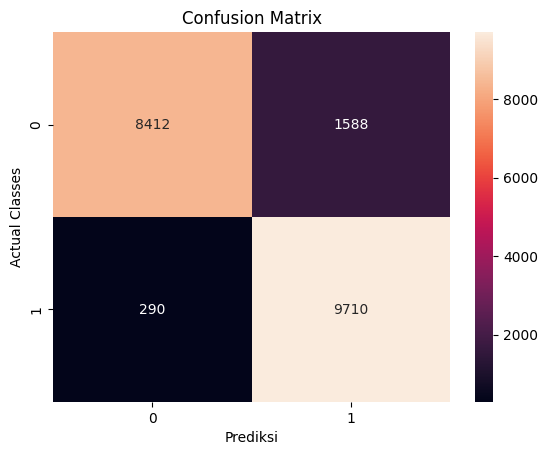

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Asumsikan `true_labels` dan `binary_predictions` sudah tersedia
true_labels = test_dataset.classes

# Buat confusion matrix
cm = confusion_matrix(true_labels, binary_predictions)

# Tampilkan heatmap tanpa notasi eksponensial
sns.heatmap(cm, annot=True, fmt='g')  # 'g' memastikan format angka biasa
plt.title("Confusion Matrix")
plt.xlabel("Prediksi")
plt.ylabel("Actual Classes")
plt.show()

# Print classification report
report = classification_report(true_labels, binary_predictions, output_dict=True)

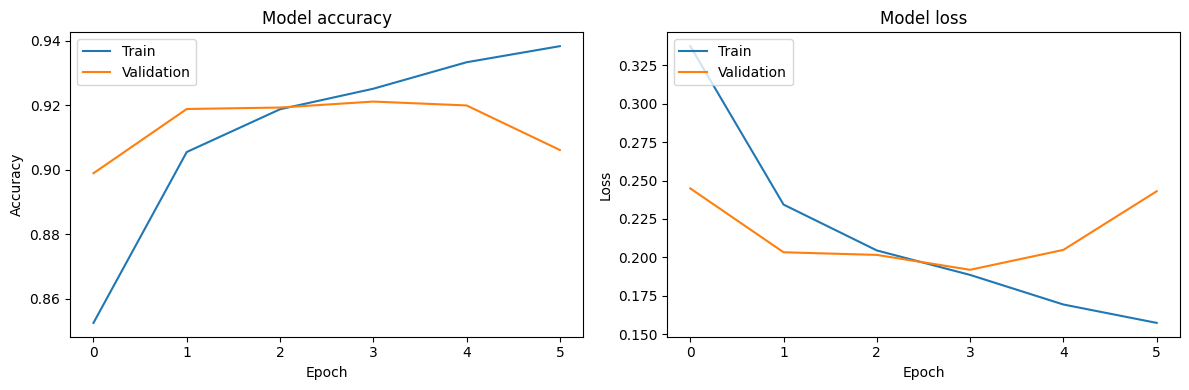

In [14]:
# Plot accuracy and loss
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [15]:
# simpan model
model_save = model1.save('model_skenario1.h5')

## Skenario 2

In [16]:
# # mendefinisikan model
# model2 = models.Sequential()

# # convolutional layers
# model2.add(layers.Conv2D(32, (3, 3), activation = 'relu', input_shape=(weight, height, 3) ))
# model2.add(layers.MaxPooling2D((2, 2)))
# model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model2.add(layers.MaxPooling2D((2, 2)))
# model2.add(layers.Conv2D(128, (3, 3)))
# model2.add(layers.MaxPooling2D((2, 2)))
# model2.add(layers.Conv2D(256, (3, 3)))
# model2.add(layers.MaxPooling2D((2, 2)))
# # Flatten layer
# model2.add(layers.Flatten())

# # dense layers
# model2.add(layers.Dense(512, activation='relu'))
# model2.add(layers.Dropout(0.5))
# model2.add(layers.Dense(1, activation='sigmoid'))
# Mendefinisikan model
model2 = models.Sequential()

# Convolutional layers
model2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(weight, height, 3), padding='same'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model2.add(layers.MaxPooling2D((2, 2)))

# Flatten layer
model2.add(layers.Flatten())

# Dense layers
model2.add(layers.Dense(512, activation='relu'))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(1, activation='sigmoid'))


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 913,729 (3.49 MB)

 Trainable params: 913,729 (3.49 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# optimizer adam dan learning rate 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

model2.compile(optimizer= optimizer, loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=2)

In [19]:
history = model2.fit(train_dataset,
                    epochs = 100,
                    validation_data = test_dataset,callbacks=[callback])

Epoch 1/100
   8/3125 ━━━━━━━━━━━━━━━━━━━━ 1:14 24ms/step - accuracy: 0.4370 - loss: 0.7117 - precision_1: 0.4304 - recall_1: 0.4656

W0000 00:00:1717185005.654436      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3123/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8418 - loss: 0.3459 - precision_1: 0.8366 - recall_1: 0.8503

W0000 00:00:1717185100.940725      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 120s 36ms/step - accuracy: 0.8419 - loss: 0.3459 - precision_1: 0.8366 - recall_1: 0.8503 - val_accuracy: 0.9216 - val_loss: 0.1987 - val_precision_1: 0.9267 - val_recall_1: 0.9157
Epoch 2/100
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 105s 33ms/step - accuracy: 0.9234 - loss: 0.1953 - precision_1: 0.9220 - recall_1: 0.9262 - val_accuracy: 0.9334 - val_loss: 0.1737 - val_precision_1: 0.9144 - val_recall_1: 0.9564
Epoch 3/100
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 107s 34ms/step - accuracy: 0.9382 - loss: 0.1603 - precision_1: 0.9388 - recall_1: 0.9369 - val_accuracy: 0.9368 - val_loss: 0.1659 - val_precision_1: 0.9154 - val_recall_1: 0.9625
Epoch 4/100
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 109s 35ms/step - accuracy: 0.9445 - loss: 0.1441 - precision_1: 0.9430 - recall_1: 0.9465 - val_accuracy: 0.9403 - val_loss: 0.1611 - val_precision_1: 0.9281 - val_recall_1: 0.9545
Epoch 5/100
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 114s 36ms/step - accuracy: 0.9516 - loss: 0.1279 - precision_1: 0.9512 - 

#### Prediksi data test

In [20]:
# buat prediksi
prediksi = model2.predict(test_dataset)

625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step


In [21]:
binary_predictions = (prediksi > 0.5).astype(int)
binary_predictions

array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [0]])

In [22]:
# Make predictions on the test data
predict_prob = model2.predict(test_dataset)
labels = [0 if pred < 0.5 else 1 for pred in predict_prob]

# Calculate accuracy
accuracy = np.sum(np.array(test_dataset.labels) == np.array(labels)) / len(labels)

# Print the accuracy
print("\nAccuracy:", accuracy)

cm = confusion_matrix(test_dataset.labels, labels)
print("\nConfusion Matrix:")
print(cm)

# Compute the classification report
class_names = test_dataset.class_indices.keys()
classification_rep = classification_report(test_dataset.labels, labels, target_names=class_names)
print("\nClassification Report:")
print(classification_rep)

# Calculate the average precision (mAP)
mAP = average_precision_score(test_dataset.labels,  predict_prob)
print("\nMean Average Precision (mAP):", mAP)

625/625 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step

Accuracy: 0.94515

Confusion Matrix:
[[9331  669]
 [ 428 9572]]

Classification Report:
              precision    recall  f1-score   support

        FAKE       0.96      0.93      0.94     10000
        REAL       0.93      0.96      0.95     10000

    accuracy                           0.95     20000
   macro avg       0.95      0.95      0.95     20000
weighted avg       0.95      0.95      0.95     20000


Mean Average Precision (mAP): 0.9884449277670222


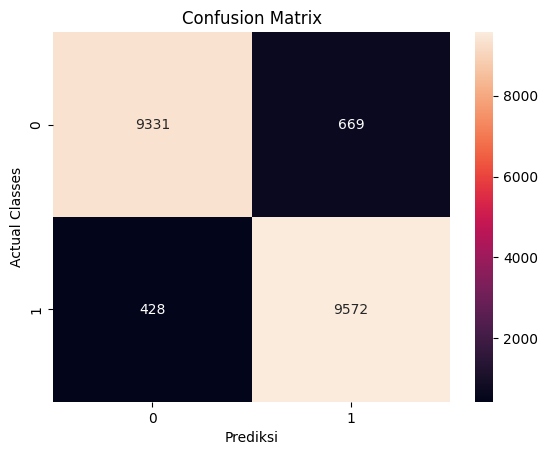

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Asumsikan `true_labels` dan `binary_predictions` sudah tersedia
true_labels = test_dataset.classes

# Buat confusion matrix
cm = confusion_matrix(true_labels, binary_predictions)

# Tampilkan heatmap tanpa notasi eksponensial
sns.heatmap(cm, annot=True, fmt='g')  # 'g' memastikan format angka biasa
plt.title("Confusion Matrix")
plt.xlabel("Prediksi")
plt.ylabel("Actual Classes")
plt.show()

# Print classification report
report = classification_report(true_labels, binary_predictions, output_dict=True)

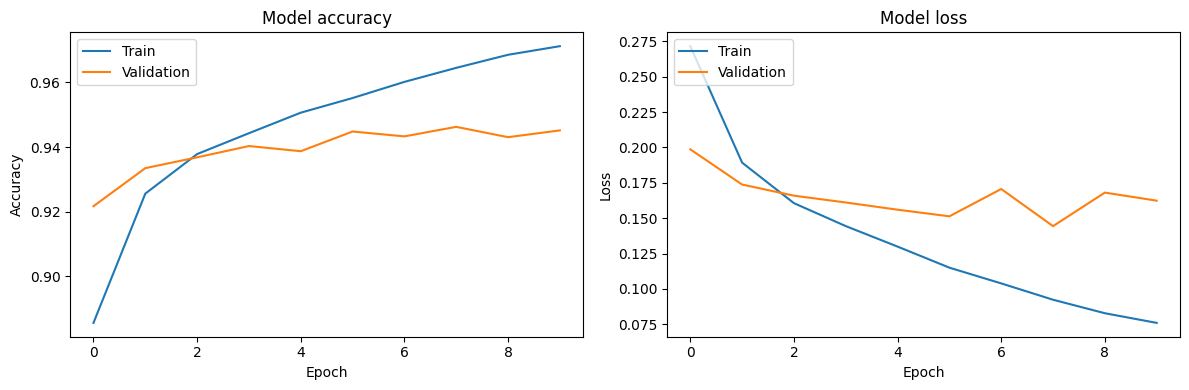

In [24]:
# Plot accuracy and loss
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [25]:
# simpan model
model_save = model2.save('model_skenario2.h5')

## Skenario Transfer Learning VGG16

In [26]:
baseModel = tf.keras.applications.VGG16(weights="imagenet", include_top=False,
                                        input_tensor=Input(shape=(32, 32, 3)))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [27]:
headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dense(1, activation="sigmoid")(headModel)

modelVGG16 = Model(inputs=baseModel.input, outputs=headModel)

In [28]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
modelVGG16.compile(
    optimizer = optimizer,
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=2)

In [29]:
history = modelVGG16.fit(train_dataset,
                    validation_data=test_dataset,
                    epochs=100,callbacks=[callback]
)

Epoch 1/100
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 128s 37ms/step - accuracy: 0.7757 - loss: 0.4507 - precision_2: 0.7751 - recall_2: 0.7734 - val_accuracy: 0.8944 - val_loss: 0.2421 - val_precision_2: 0.9467 - val_recall_2: 0.8359
Epoch 2/100
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 112s 36ms/step - accuracy: 0.8935 - loss: 0.2581 - precision_2: 0.8986 - recall_2: 0.8875 - val_accuracy: 0.9124 - val_loss: 0.2215 - val_precision_2: 0.9004 - val_recall_2: 0.9274
Epoch 3/100
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 112s 36ms/step - accuracy: 0.9176 - loss: 0.2065 - precision_2: 0.9188 - recall_2: 0.9145 - val_accuracy: 0.9291 - val_loss: 0.1797 - val_precision_2: 0.9504 - val_recall_2: 0.9055
Epoch 4/100
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 112s 36ms/step - accuracy: 0.9372 - loss: 0.1623 - precision_2: 0.9387 - recall_2: 0.9354 - val_accuracy: 0.9389 - val_loss: 0.1503 - val_precision_2: 0.9144 - val_recall_2: 0.9684
Epoch 5/100
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 145s 37ms/step - accuracy: 0.9031 - loss: 0.2564 - precision_

In [30]:
# buat prediksi
prediksi = modelVGG16.predict(test_dataset)

625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 37ms/step


In [31]:
binary_predictions = (prediksi > 0.5).astype(int)
binary_predictions

array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [0]])

In [32]:
# Make predictions on the test data
predict_prob = modelVGG16.predict(test_dataset)
labels = [0 if pred < 0.5 else 1 for pred in predict_prob]

# Calculate accuracy
accuracy = np.sum(np.array(test_dataset.labels) == np.array(labels)) / len(labels)

# Print the accuracy
print("\nAccuracy:", accuracy)

cm = confusion_matrix(test_dataset.labels, labels)
print("\nConfusion Matrix:")
print(cm)

# Compute the classification report
class_names = test_dataset.class_indices.keys()
classification_rep = classification_report(test_dataset.labels, labels, target_names=class_names)
print("\nClassification Report:")
print(classification_rep)

# Calculate the average precision (mAP)
mAP = average_precision_score(test_dataset.labels,  predict_prob)
print("\nMean Average Precision (mAP):", mAP)

625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step

Accuracy: 0.9079

Confusion Matrix:
[[8423 1577]
 [ 265 9735]]

Classification Report:
              precision    recall  f1-score   support

        FAKE       0.97      0.84      0.90     10000
        REAL       0.86      0.97      0.91     10000

    accuracy                           0.91     20000
   macro avg       0.92      0.91      0.91     20000
weighted avg       0.92      0.91      0.91     20000


Mean Average Precision (mAP): 0.9795770854399748


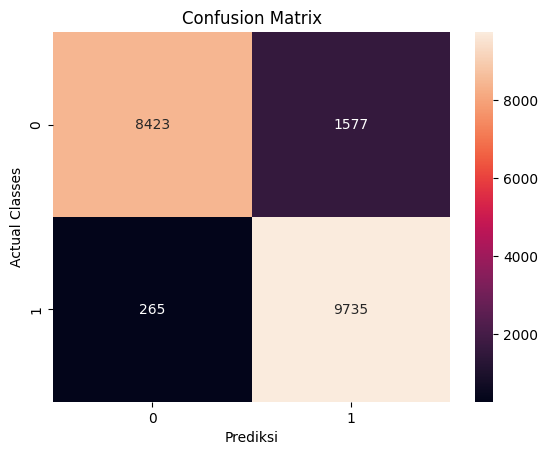

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Asumsikan `true_labels` dan `binary_predictions` sudah tersedia
true_labels = test_dataset.classes

# Buat confusion matrix
cm = confusion_matrix(true_labels, binary_predictions)

# Tampilkan heatmap tanpa notasi eksponensial
sns.heatmap(cm, annot=True, fmt='g')  # 'g' memastikan format angka biasa
plt.title("Confusion Matrix")
plt.xlabel("Prediksi")
plt.ylabel("Actual Classes")
plt.show()

# Print classification report
report = classification_report(true_labels, binary_predictions, output_dict=True)

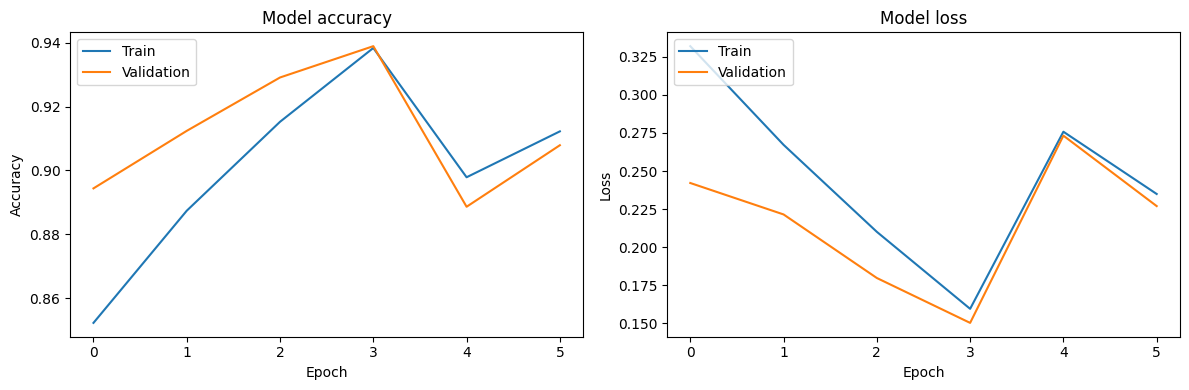

In [34]:
# Plot accuracy and loss
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [35]:
# simpan model
model_save = modelVGG16.save('model_vgg16.h5')

In [36]:
# define dependency 
from tensorflow.keras.models import load_model

# load model 
model = load_model('model_vgg16.h5')

# check model info 
model.summary()

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,879,043 (56.76 MB)

 Trainable params: 14,879,041 (56.76 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

### Test data diluar dataset

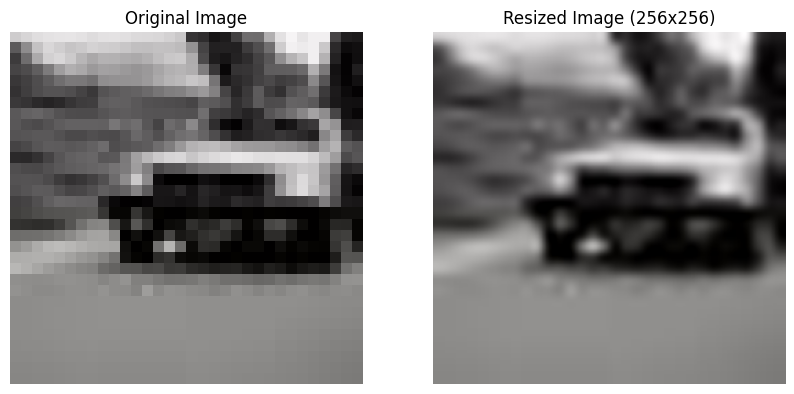

In [37]:
from PIL import Image
import matplotlib.pyplot as plt

# Open the original image
im = Image.open("/kaggle/input/cifake-real-and-ai-generated-synthetic-images/train/FAKE/1000 (2).jpg")

# Define the new size
new_size = (256, 256)

# Resize the image
im_resized = im.resize(new_size)

# Plot the original and resized images
plt.figure(figsize=(10, 5))

# Plot the original image
plt.subplot(1, 2, 1)
plt.imshow(im)
plt.title('Original Image')
plt.axis('off')

# Plot the resized image
plt.subplot(1, 2, 2)
plt.imshow(im_resized)
plt.title('Resized Image (256x256)')
plt.axis('off')

plt.show()

In [38]:
# test_dir = "/kaggle/input/data-testing/data luar"
test_dir = "/kaggle/input/data-testing/data_luar_v2/data_luar_v2"

In [39]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(32,32),
                                                  class_mode='binary', shuffle=False)

Found 20 images belonging to 2 classes.


In [40]:
model1 = load_model('/kaggle/working/model_skenario1.h5')
model2 = load_model('/kaggle/working/model_skenario2.h5')
modelVGG16 = load_model('/kaggle/working/model_vgg16.h5')

#### akurasi model

In [41]:
# model 1
scores = model1.evaluate(test_generator)

print('Baseline error: %.2f' % (1-scores[1]))
print("Accuracy = %.2f" %scores[1])

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6000 - loss: 1.2872 - precision: 0.5556 - recall: 1.0000
Baseline error: 0.40
Accuracy = 0.60


In [42]:
# model 2
scores = model2.evaluate(test_generator)

print('Baseline error: %.2f' % (1-scores[1]))
print("Accuracy = %.2f" %scores[1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6000 - loss: 2.2546 - precision_1: 0.5556 - recall_1: 1.0000
Baseline error: 0.40
Accuracy = 0.60


W0000 00:00:1717187152.682354      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [43]:
# model vgg16
scores = modelVGG16.evaluate(test_generator)

print('Baseline error: %.2f' % (1-scores[1]))
print("Accuracy = %.2f" %scores[1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.6000 - loss: 0.8740 - precision_2: 0.5625 - recall_2: 0.9000
Baseline error: 0.40
Accuracy = 0.60


W0000 00:00:1717187162.854811      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [44]:
# Make predictions on the test data
predict_prob = model1.predict(test_generator)
labels = [0 if pred < 0.5 else 1 for pred in predict_prob]

# Calculate accuracy
accuracy = np.sum(np.array(test_generator.labels) == np.array(labels)) / len(labels)

# Print the accuracy
print("\nAccuracy:", accuracy)

cm = confusion_matrix(test_generator.labels, labels)
print("\nConfusion Matrix:")
print(cm)

# Compute the classification report
class_names = test_generator.class_indices.keys()
classification_rep = classification_report(test_generator.labels, labels, target_names=class_names)
print("\nClassification Report:")
print(classification_rep)

# Calculate the average precision (mAP)
mAP = average_precision_score(test_generator.labels,  predict_prob)
print("\nMean Average Precision (mAP):", mAP)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step

Accuracy: 0.6

Confusion Matrix:
[[ 2  8]
 [ 0 10]]

Classification Report:
              precision    recall  f1-score   support

        FAKE       1.00      0.20      0.33        10
        REAL       0.56      1.00      0.71        10

    accuracy                           0.60        20
   macro avg       0.78      0.60      0.52        20
weighted avg       0.78      0.60      0.52        20


Mean Average Precision (mAP): 0.8043253968253967


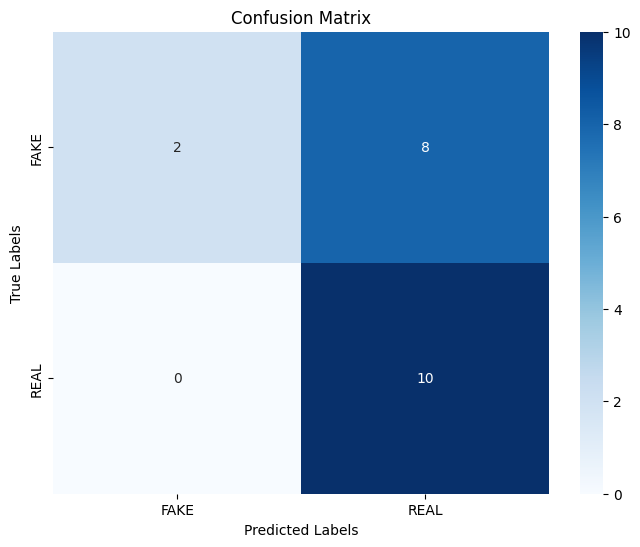

In [45]:
import seaborn as sns

# Confusion matrix
cm = confusion_matrix(test_generator.labels, labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [46]:
# Make predictions on the test data
predict_prob = model2.predict(test_generator)
labels = [0 if pred < 0.5 else 1 for pred in predict_prob]

# Calculate accuracy
accuracy = np.sum(np.array(test_generator.labels) == np.array(labels)) / len(labels)

# Print the accuracy
print("\nAccuracy:", accuracy)

cm = confusion_matrix(test_generator.labels, labels)
print("\nConfusion Matrix:")
print(cm)

# Compute the classification report
class_names = test_generator.class_indices.keys()
classification_rep = classification_report(test_generator.labels, labels, target_names=class_names)
print("\nClassification Report:")
print(classification_rep)

# Calculate the average precision (mAP)
mAP = average_precision_score(test_generator.labels,  predict_prob)
print("\nMean Average Precision (mAP):", mAP)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step

Accuracy: 0.6

Confusion Matrix:
[[ 2  8]
 [ 0 10]]

Classification Report:
              precision    recall  f1-score   support

        FAKE       1.00      0.20      0.33        10
        REAL       0.56      1.00      0.71        10

    accuracy                           0.60        20
   macro avg       0.78      0.60      0.52        20
weighted avg       0.78      0.60      0.52        20


Mean Average Precision (mAP): 0.7694857430151547


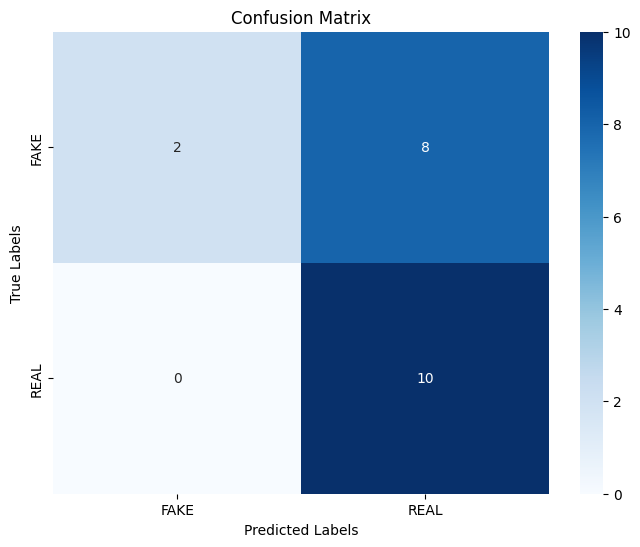

In [47]:
import seaborn as sns

# Confusion matrix
cm = confusion_matrix(test_generator.labels, labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [48]:
# Make predictions on the test data
predict_prob = modelVGG16.predict(test_generator)
labels = [0 if pred < 0.5 else 1 for pred in predict_prob]

# Calculate accuracy
accuracy = np.sum(np.array(test_generator.labels) == np.array(labels)) / len(labels)

# Print the accuracy
print("\nAccuracy:", accuracy)

cm = confusion_matrix(test_generator.labels, labels)
print("\nConfusion Matrix:")
print(cm)

# Compute the classification report
class_names = test_generator.class_indices.keys()
classification_rep = classification_report(test_generator.labels, labels, target_names=class_names)
print("\nClassification Report:")
print(classification_rep)

# Calculate the average precision (mAP)
mAP = average_precision_score(test_generator.labels,  predict_prob)
print("\nMean Average Precision (mAP):", mAP)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step

Accuracy: 0.6

Confusion Matrix:
[[3 7]
 [1 9]]

Classification Report:
              precision    recall  f1-score   support

        FAKE       0.75      0.30      0.43        10
        REAL       0.56      0.90      0.69        10

    accuracy                           0.60        20
   macro avg       0.66      0.60      0.56        20
weighted avg       0.66      0.60      0.56        20


Mean Average Precision (mAP): 0.8249879205761558


W0000 00:00:1717187198.562063      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


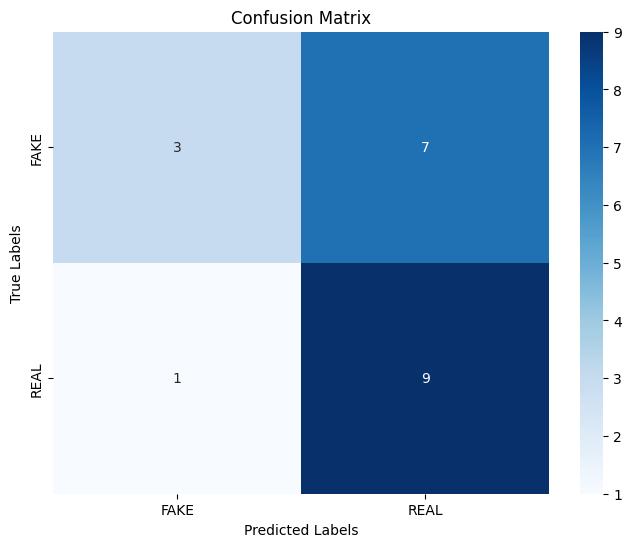

In [49]:
import seaborn as sns

# Confusion matrix
cm = confusion_matrix(test_generator.labels, labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### Coba skenario 2 layer konvolusi

In [50]:
# mendefinisikan model
model = models.Sequential()

# convolutional layers
model.add(layers.Conv2D(32, (3, 3), activation = 'relu', input_shape=(weight, height, 3) ))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))


# Flatten layer
model.add(layers.Flatten())

# dense layers
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [51]:
# optimizer adam dan learning rate 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
model.compile(optimizer= optimizer, loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=2)

In [52]:
# summary model
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 13, 13, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,001 (328.13 KB)

 Trainable params: 84,001 (328.13 KB)

 Non-trainable params: 0 (0.00 B)

In [53]:
history = model.fit(train_dataset,
                    validation_data=test_dataset,
                    epochs=100,callbacks=[callback]
)

Epoch 1/100
   8/3125 ━━━━━━━━━━━━━━━━━━━━ 1:26 28ms/step - accuracy: 0.4335 - loss: 0.7170 - precision_3: 0.4164 - recall_3: 0.4469

W0000 00:00:1717187241.232316      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3118/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8007 - loss: 0.4172 - precision_3: 0.7914 - recall_3: 0.8124

W0000 00:00:1717187342.305556      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 122s 38ms/step - accuracy: 0.8009 - loss: 0.4170 - precision_3: 0.7915 - recall_3: 0.8125 - val_accuracy: 0.8876 - val_loss: 0.2672 - val_precision_3: 0.8457 - val_recall_3: 0.9482
Epoch 2/100
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 116s 37ms/step - accuracy: 0.9027 - loss: 0.2376 - precision_3: 0.8989 - recall_3: 0.9070 - val_accuracy: 0.9208 - val_loss: 0.1988 - val_precision_3: 0.9116 - val_recall_3: 0.9321
Epoch 3/100
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 115s 37ms/step - accuracy: 0.9209 - loss: 0.2001 - precision_3: 0.9195 - recall_3: 0.9227 - val_accuracy: 0.9272 - val_loss: 0.1816 - val_precision_3: 0.9388 - val_recall_3: 0.9139
Epoch 4/100
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 111s 35ms/step - accuracy: 0.9293 - loss: 0.1773 - precision_3: 0.9283 - recall_3: 0.9309 - val_accuracy: 0.9237 - val_loss: 0.1906 - val_precision_3: 0.9051 - val_recall_3: 0.9467
Epoch 5/100
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 114s 36ms/step - accuracy: 0.9349 - loss: 0.1618 - precision_3: 0.9339 - 

In [54]:
# buat prediksi
prediksi = model.predict(test_dataset)

625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step


In [55]:
binary_predictions = (prediksi > 0.5).astype(int)
binary_predictions

array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [0]])

In [56]:
# Make predictions on the test data
predict_prob = model.predict(test_dataset)
labels = [0 if pred < 0.5 else 1 for pred in predict_prob]

# Calculate accuracy
accuracy = np.sum(np.array(test_dataset.labels) == np.array(labels)) / len(labels)

# Print the accuracy
print("\nAccuracy:", accuracy)

cm = confusion_matrix(test_dataset.labels, labels)
print("\nConfusion Matrix:")
print(cm)

# Compute the classification report
class_names = test_dataset.class_indices.keys()
classification_rep = classification_report(test_dataset.labels, labels, target_names=class_names)
print("\nClassification Report:")
print(classification_rep)

# Calculate the average precision (mAP)
mAP = average_precision_score(test_dataset.labels,  predict_prob)
print("\nMean Average Precision (mAP):", mAP)

625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step

Accuracy: 0.92685

Confusion Matrix:
[[8938 1062]
 [ 401 9599]]

Classification Report:
              precision    recall  f1-score   support

        FAKE       0.96      0.89      0.92     10000
        REAL       0.90      0.96      0.93     10000

    accuracy                           0.93     20000
   macro avg       0.93      0.93      0.93     20000
weighted avg       0.93      0.93      0.93     20000


Mean Average Precision (mAP): 0.9831288722076961


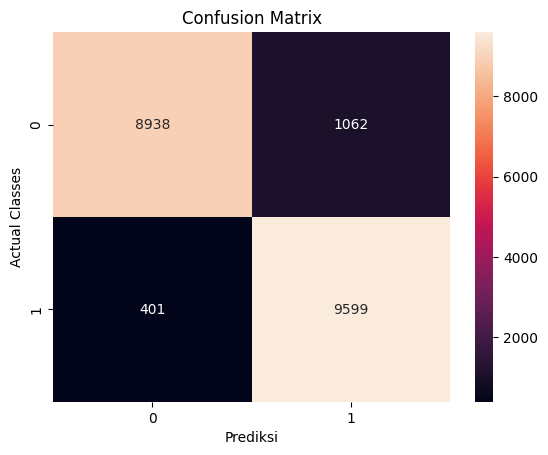

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Asumsikan `true_labels` dan `binary_predictions` sudah tersedia
true_labels = test_dataset.classes

# Buat confusion matrix
cm = confusion_matrix(true_labels, binary_predictions)

# Tampilkan heatmap tanpa notasi eksponensial
sns.heatmap(cm, annot=True, fmt='g')  # 'g' memastikan format angka biasa
plt.title("Confusion Matrix")
plt.xlabel("Prediksi")
plt.ylabel("Actual Classes")
plt.show()

# Print classification report
report = classification_report(true_labels, binary_predictions, output_dict=True)

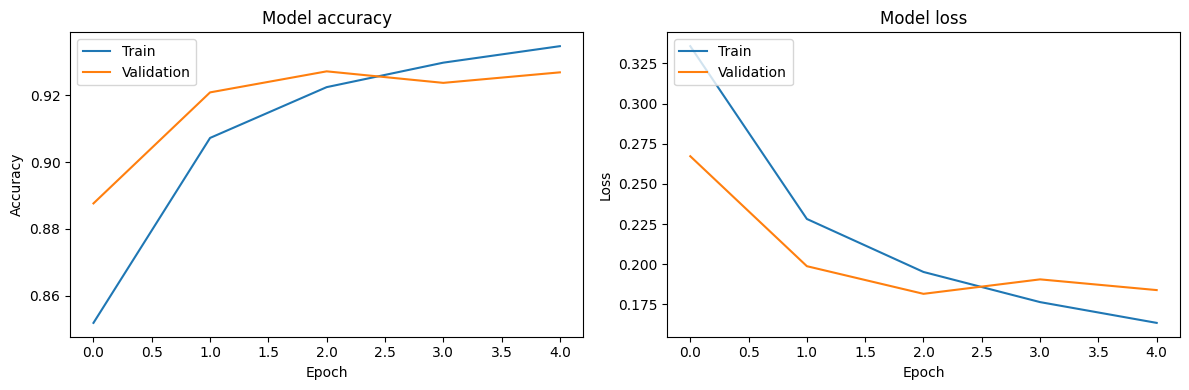

In [58]:
# Plot accuracy and loss
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [59]:
# simpan model
model_save = model.save('model_skenario0.h5')

In [60]:
# model 1
scores = model.evaluate(test_generator)

print('Baseline error: %.2f' % (1-scores[1]))
print("Accuracy = %.2f" %scores[1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step - accuracy: 0.7000 - loss: 0.9830 - precision_3: 0.6250 - recall_3: 1.0000
Baseline error: 0.30
Accuracy = 0.70


W0000 00:00:1717187919.339703      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [61]:
# Make predictions on the test data
predict_prob = model.predict(test_generator)
labels = [0 if pred < 0.5 else 1 for pred in predict_prob]

# Calculate accuracy
accuracy = np.sum(np.array(test_generator.labels) == np.array(labels)) / len(labels)

# Print the accuracy
print("\nAccuracy:", accuracy)

cm = confusion_matrix(test_generator.labels, labels)
print("\nConfusion Matrix:")
print(cm)

# Compute the classification report
class_names = test_generator.class_indices.keys()
classification_rep = classification_report(test_generator.labels, labels, target_names=class_names)
print("\nClassification Report:")
print(classification_rep)

# Calculate the average precision (mAP)
mAP = average_precision_score(test_generator.labels,  predict_prob)
print("\nMean Average Precision (mAP):", mAP)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step

Accuracy: 0.7

Confusion Matrix:
[[ 4  6]
 [ 0 10]]

Classification Report:
              precision    recall  f1-score   support

        FAKE       1.00      0.40      0.57        10
        REAL       0.62      1.00      0.77        10

    accuracy                           0.70        20
   macro avg       0.81      0.70      0.67        20
weighted avg       0.81      0.70      0.67        20


Mean Average Precision (mAP): 0.7977272727272726


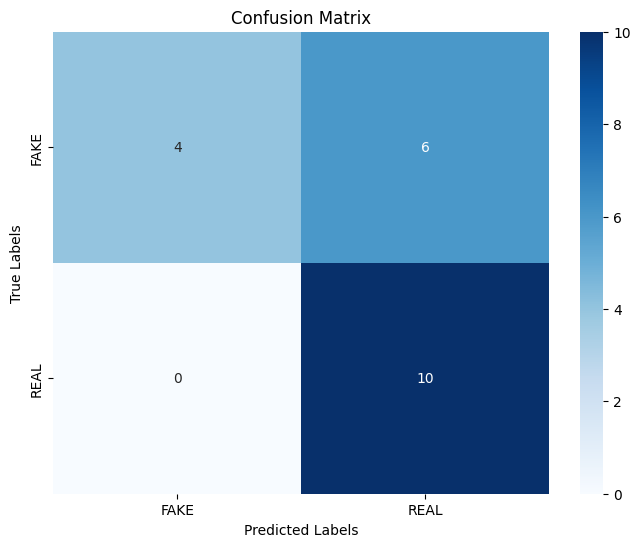

In [62]:
import seaborn as sns

# Confusion matrix
cm = confusion_matrix(test_generator.labels, labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

#### display image real and fake

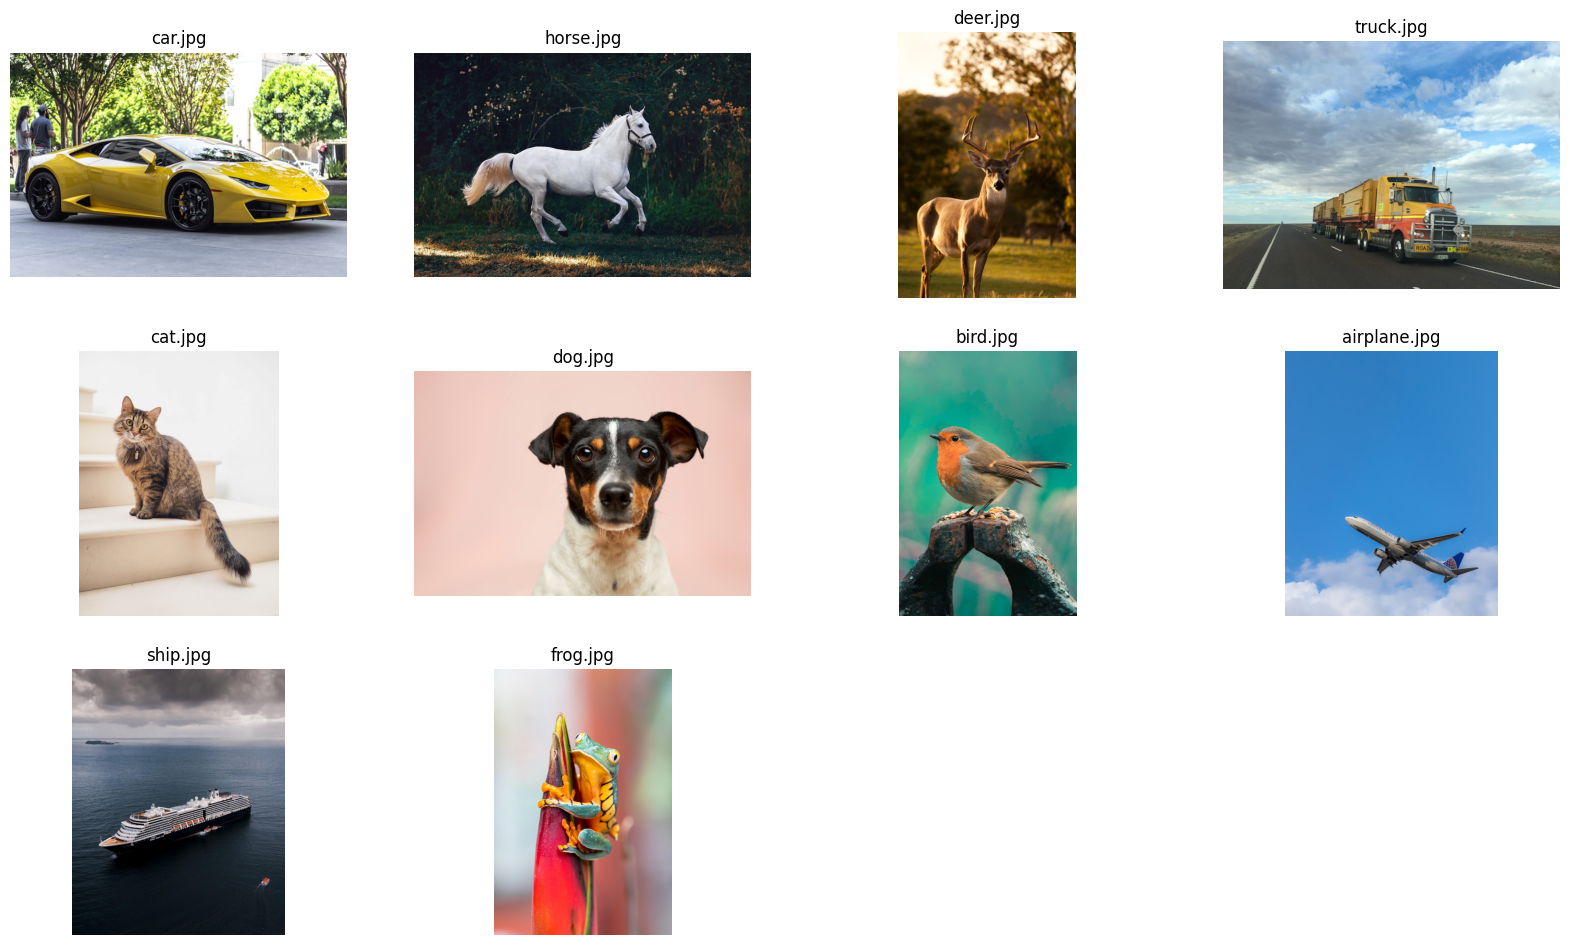

In [63]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Directory containing the images
data_dir = '/kaggle/input/data-testing/data luar/data luar/REAL'

# Get a list of all files in the directory
image_files = os.listdir(data_dir)

# Filter out directories from the list of files
image_files = [f for f in image_files if os.path.isfile(os.path.join(data_dir, f))]

# Display the images
plt.figure(figsize=(20, 20))

for i, image_file in enumerate(image_files):
    img = mpimg.imread(os.path.join(data_dir, image_file))
    plt.subplot(5, 4, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(image_file)

# Save the figure
plt.savefig('displayed_images_real.png')

# Show the figure
plt.show()


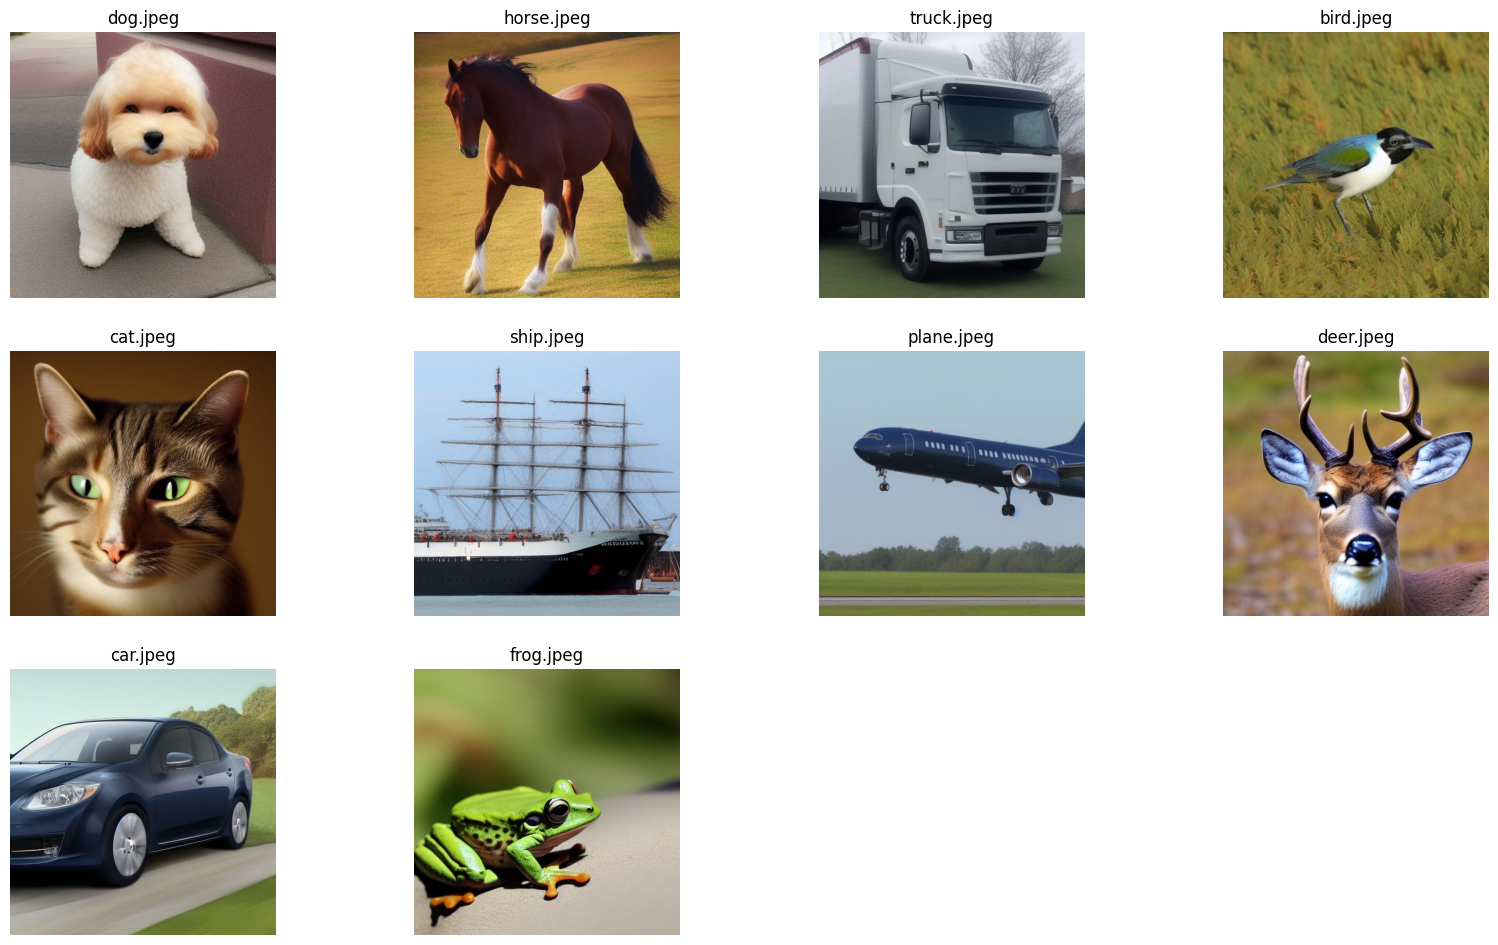

In [64]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Directory containing the images
data_dir = '/kaggle/input/data-testing/data luar/data luar/FAKE'

# Get a list of all files in the directory
image_files = os.listdir(data_dir)

# Filter out directories from the list of files
image_files = [f for f in image_files if os.path.isfile(os.path.join(data_dir, f))]

# Display the images
plt.figure(figsize=(20, 20))

for i, image_file in enumerate(image_files):
    img = mpimg.imread(os.path.join(data_dir, image_file))
    plt.subplot(5, 4, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(image_file)

# Save the figure
plt.savefig('displayed_images_fake.png')

# Show the figure
plt.show()